In [150]:
import numpy

from finance_utils.namedtuples import *
from finance_utils.uniontypes import *
from finance_utils.asset.spot.base import Spot,ServiceChargesSpot
# from finance_utils.asset.spot.strategy import SpotCostAveragingPlan
from finance_utils.strategy.dca import simple_dca, price_qualified_dca

from finance_utils.process.prices.gbm import RVDecoupledGBM, GBM, NormalDistribution
from finance_utils.trader.base import Trader
from finance_utils.trader.utility import *

from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist, KernelMixDist, SmoothHisDist
from data_utils.stochastic_utils.random_process.correlatedRandom import random_correlated_series
from easy_datetime.timestamp import TimeStamp
import tqdm

from matplotlib import pyplot

In [151]:
class Test:
    def __init__(
            self, 
            weekdays=22,
            months=12,
    ):
        self.weekdays = weekdays
        self.months = months
        self.days = self.weekdays * self.months
        self.stocks:list[Spot] = []
        self.processes:list[RVDecoupledGBM] = []
        
    def new_processes(self, rr=(0.03, 0.03), v=(0.015, 0.015), corr=(0,0)):
        self.stocks = []
        self.processes = []
        
        num = len(rr)
        d = []
        for i in range(num):
            d.append(NormalDistribution(rr[i] / self.days, v[i]))
            
        if num > 1:
            rs = random_correlated_series(d, corr, self.days)
        else:
            rs = [d[0].rvf(self.days)]
        for i in range(num):
            self.stocks.append(
                ServiceChargesSpot(f"{i}", 1, TradeDelta("day", 1), 5e-5, 5e-4)
            )
            self.processes.append(
                RVDecoupledGBM(f"{i}", rs[i], 1, TimeStamp.now().accurate_to("year"), "day", 1)
            )
            
    def path_data(self):
        d = []
        for p in self.processes:
            d.append(p.price)
        return d
        
        
            
    def simple_dca_trade(self, capital, trade_interval = 1):
        index_list = []
        yield_list = []
        trigger_set = set(range(0, self.days, trade_interval))
        cap = capital / len(trigger_set)
        
        
        num = len(self.stocks)
        simple_traders = [Trader(f"s_trader_{i}", capital, None) for i in range(num)]
        
        for i, t, _ in self.processes[0].process_iter():
            trader_yield = 0
            index_yield = 0
            for n in range(num):
                path = self.processes[n][i]
                index_yield += path.price
                
                _, _ = simple_dca(self.processes[n].s0, i, t, path, self.stocks[n], simple_traders[n], cap, trigger_set)
                trader_yield += simple_traders[n].net_worth_rate(**path.dic)
            index_list.append(index_yield / num)
            yield_list.append(trader_yield/ num)
            
        return index_list, yield_list
    
    def price_qualified_dca_trade(self, capital, pr=0.99,sr=1.01, trade_interval = 1):
        index_list = []
        yield_list = []
        trigger_set = list(range(0, self.days, trade_interval))
        
        unit_cap = capital / len(trigger_set)
           
        num = len(self.stocks)
        price_qualified_traders = [Trader(f"p_trader_{i}", capital, None) for i in range(num)]
        
        for i, t, _ in self.processes[0].process_iter():
            trader_yield = 0
            index_yield = 0
            for n in range(num):
                if i in trigger_set:
                    cap = price_qualified_traders[n].capital - len(trigger_set[trigger_set.index(i):]) * unit_cap
                else:
                    pass
                path = self.processes[n][i]
                index_yield += path.price
                
                _, _ = price_qualified_dca(self.processes[n].s0, i, t, path, self.stocks[n], price_qualified_traders[n], cap, trigger_set, pr, sr)
                trader_yield += price_qualified_traders[n].net_worth_rate(**path.dic)
            index_list.append(index_yield / num)
            yield_list.append(trader_yield/ num)
            
        return numpy.array(index_list), numpy.array(yield_list)

In [160]:
test = Test(
    22,
    12
)


In [167]:
test.new_processes([0.03] * 1, [0.015] * 1,[0] * 1)

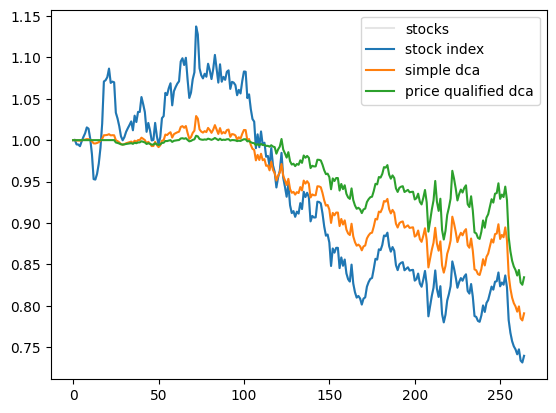

In [168]:
p = test.path_data()

spot, sdt = test.simple_dca_trade(200000,22)
_, pqdt = test.price_qualified_dca_trade(200000, 0.9, 1.1, 22)

for i, pi in enumerate(p):
    if i == 0:
        pyplot.plot(pi, alpha=0.2, color="gray", label="stocks")
    else:
        pyplot.plot(pi, alpha=0.2, color="gray")

pyplot.plot(spot, label="stock index")
pyplot.plot(sdt, label="simple dca")
pyplot.plot(pqdt, label="price qualified dca")
pyplot.legend()
pyplot.show()

In [157]:
epoch = 100
spot_list = []
std_list = []
for _ in tqdm.trange(epoch):
    test.new_processes([0.03] * 1, [0.015] * 1,[0] * 1)
    spot, sdt = test.simple_dca_trade(200000,22)
    spot_list.append(spot)
    std_list.append(sdt)
spot_array = numpy.array(spot_list)
std_array = numpy.array(std_list)

100%|██████████| 100/100 [00:01<00:00, 87.53it/s]


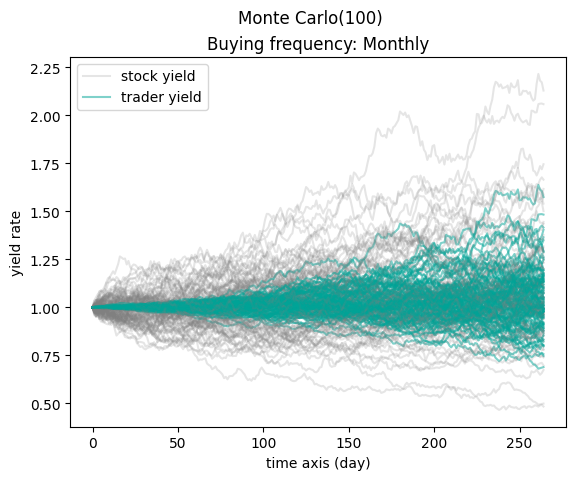

In [183]:
for i in range(epoch):
    if i == 0:
        kwargs1 = {"label":"stock yield"}
        kwargs2 = {"label":"trader yield"}
    else:
        kwargs1 = {}
        kwargs2 = {}
    pyplot.plot(spot_array[i], color="gray", alpha=0.2, **kwargs1)
    pyplot.plot(std_array[i], color="#00a497", alpha=0.5, **kwargs2)

pyplot.suptitle("Monte Carlo(100)")
pyplot.title("Buying frequency: Monthly")
pyplot.xlabel("time axis (day)")
pyplot.ylabel("yield rate")
pyplot.legend()
pyplot.show()

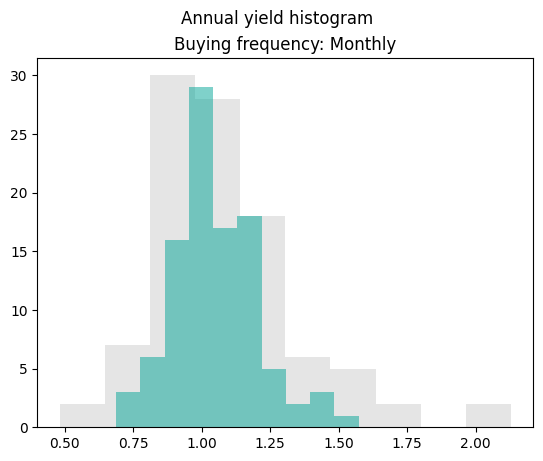

In [192]:

pyplot.hist(spot_array[:,-1],color="gray", alpha=0.2)
pyplot.hist(std_array[:,-1],  color="#00a497", alpha=0.5)
pyplot.suptitle("Annual yield histogram")
pyplot.title("Buying frequency: Monthly")
pyplot.show()